# **Type 1 Diabetes Classification System Using Gene Expression Biomarkers**

This project develops a specialized machine learning pipeline for the accurate classification of Type 1 Diabetes (T1D) using gene expression biomarkers. Leveraging RNA-seq datasets, the system incorporates advanced preprocessing, feature selection, and model optimization techniques to identify key genetic signatures associated with T1D. Ensemble learning strategies are applied to improve robustness and predictive accuracy, enabling the model to distinguish T1D cases from healthy controls with high reliability.

### **Import Libraries**

Before beginning any data analysis or modeling, it is essential to import all required libraries. This project leverages a wide range of tools for data manipulation, visualization, machine learning, and hyperparameter optimization. Libraries such as pandas and numpy handle data structures and numerical operations, while matplotlib and seaborn enable effective data visualization. For machine learning, classifiers like RandomForest, XGBoost, and SVM are imported, along with preprocessing tools like StandardScaler and KNNImputer. Feature selection methods including LassoCV and statistical tests (ttest_ind) are used to identify biologically relevant genes. Additionally, Optuna supports efficient hyperparameter tuning, and imblearn helps manage potential class imbalances. The tqdm library provides progress bars for long-running loops, improving user experience during model training and cross-validation.

In [461]:
# Import necessary libraries
import joblib
import optuna
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from tqdm.notebook import tqdm

In [380]:
import warnings
warnings.filterwarnings('ignore')

### **Load and Merge Datasets**

The foundation of this study lies in integrating gene expression data from two publicly available RNA-seq datasets: GSE151610 and GSE169221, sourced from the Gene Expression Omnibus (GEO). These datasets provide gene-level count matrices and corresponding metadata for individuals with Type 1 Diabetes and healthy controls. By combining data from multiple studies, we increase statistical power and improve the generalizability of our findings. The count matrices contain gene expression levels across samples, while the metadata files include sample conditions and experimental details. Loading both datasets simultaneously allows for consistent preprocessing and harmonization before downstream analysis.

In [ ]:
# Load and merge T1D datasets
data_paths = {

    "t1d_counts": ["Data/GSE151610_GeneLevel_Raw_data.csv", "Data/GSE169221_GeneLevel_Raw_data.csv"],
    "t1d_metadata": ["Data/GSE151610_filtered_metadata.csv", "Data/GSE169221_filtered_metadata.csv"],
}

t1d_counts_0 = pd.read_csv(data_paths["t1d_counts"][0], index_col=0)
t1d_counts_1 = pd.read_csv(data_paths["t1d_counts"][1], index_col=0)
t1d_metadata_0 = pd.read_csv(data_paths["t1d_metadata"][0])
t1d_metadata_1 = pd.read_csv(data_paths["t1d_metadata"][1])

In [382]:
t1d_metadata_0.head()

,Unnamed: 0,characteristics,emp2 expression,replicate,emp2.expression.ch1,replicate.ch1
0,GSM4586567,hypoxia_KD_1,knock down,1,knock down,1
1,GSM4586568,hypoxia_OE_1,overexpressing,1,overexpressing,1
2,GSM4586569,hypoxia_VC_1,vector control,1,vector control,1
3,GSM4586570,hypoxia_WT_1,wild type,1,wild type,1
4,GSM4586571,normoxia_KD_1,knock down,1,knock down,1


### **Preprocess Metadata Labels**

The metadata from the two datasets uses different terminologies to describe case and control groups. In GSE151610, “hypoxia” refers to T1D cases and “normoxia” to controls, while in GSE169221, “CYTO” denotes cases and “CONT” controls. To ensure consistency, we extract these condition labels using regular expressions and standardize them into a uniform format: 'case' for T1D patients and 'control' for healthy individuals. This harmonization step is crucial for accurate labeling during model training and prevents misclassification due to inconsistent annotations.

In [383]:
# Extract 'hypoxia' or 'normoxia' from characteristics and replace with 'case' or 'control'
t1d_metadata_0['characteristics'] = t1d_metadata_0['characteristics'].str.extract(r'^(hypoxia|normoxia)')[0]
t1d_metadata_0['characteristics'] = t1d_metadata_0['characteristics'].replace({'hypoxia': 'case', 'normoxia': 'control'})
t1d_metadata_0.head()

,Unnamed: 0,characteristics,emp2 expression,replicate,emp2.expression.ch1,replicate.ch1
0,GSM4586567,case,knock down,1,knock down,1
1,GSM4586568,case,overexpressing,1,overexpressing,1
2,GSM4586569,case,vector control,1,vector control,1
3,GSM4586570,case,wild type,1,wild type,1
4,GSM4586571,control,knock down,1,knock down,1


In [385]:
t1d_metadata_1.head()

,Unnamed: 0,characteristics,treatment,treatment.ch1
0,GSM5184058,CONT_1,Untreated control,Untreated control
1,GSM5184059,CONT_2,Untreated control,Untreated control
2,GSM5184060,CONT_3,Untreated control,Untreated control
3,GSM5184061,CONT_4,Untreated control,Untreated control
4,GSM5184062,CONT_5,Untreated control,Untreated control


In [386]:
# Extract 'CONT' or 'CYTO' from characteristics and replace with 'control' or 'case'
t1d_metadata_1['characteristics'] = t1d_metadata_1['characteristics'].str.extract(r'^(CONT|CYTO)')[0]
t1d_metadata_1['characteristics'] = t1d_metadata_1['characteristics'].replace({'CONT': 'control', 'CYTO': 'case'})
t1d_metadata_1.head()

,Unnamed: 0,characteristics,treatment,treatment.ch1
0,GSM5184058,control,Untreated control,Untreated control
1,GSM5184059,control,Untreated control,Untreated control
2,GSM5184060,control,Untreated control,Untreated control
3,GSM5184061,control,Untreated control,Untreated control
4,GSM5184062,control,Untreated control,Untreated control


### **Merge Counts and Metadata**

After standardizing the condition labels, the next step is to merge the gene expression matrices and metadata from both datasets. Concatenation is performed along the sample axis (rows), combining all samples into a single dataset. This integration ensures that the final dataset contains a broad representation of T1D and control samples, enhancing model robustness. The merging process retains only genes that are common across both datasets, reducing noise and avoiding excessive missing values.

In [387]:
# Merge only the common genes (index) to avoid NaN values
t1d_counts = pd.concat([t1d_counts_0, t1d_counts_1], axis=0)
t1d_metadata = pd.concat([t1d_metadata_0, t1d_metadata_1], axis=0)

print("The Shape of Data:", t1d_counts.shape)
print("Preview of Data:")
t1d_counts.head(10)

The Shape of Data: (70826, 45)
Preview of Data:


,gene_symbol,GSM4586567,GSM4586568,GSM4586569,GSM4586570,GSM4586571,GSM4586572,GSM4586573,GSM4586574,GSM4586575,...,GSM5184068,GSM5184069,GSM5184070,GSM5184071,GSM5184072,GSM5184073,GSM5184074,GSM5184075,GSM5184076,GSM5184077
ENSG00000000003,TSPAN6,596.0,832.0,478.0,662.0,596.0,672.0,453.0,811.0,717.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000000005,TNMD,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000000419,DPM1,335.0,450.0,569.0,412.0,521.0,547.0,697.0,591.0,371.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000000457,SCYL3,174.0,221.0,123.0,230.0,196.0,151.0,147.0,212.0,263.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000000460,C1orf112,61.0,116.0,131.0,152.0,68.0,102.0,116.0,175.0,63.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000000938,FGR,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000000971,CFH,3781.0,3829.0,910.0,4278.0,3914.0,3027.0,921.0,5018.0,4352.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000001036,FUCA2,2114.0,1305.0,1253.0,2349.0,2516.0,1254.0,1092.0,2966.0,2261.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000001084,GCLC,760.0,676.0,1510.0,635.0,540.0,718.0,728.0,459.0,863.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000001167,NFYA,731.0,842.0,1164.0,807.0,754.0,879.0,1186.0,840.0,729.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [388]:
print("Preview of Metadata:")
t1d_metadata.head(10)

Preview of Metadata:


,Unnamed: 0,characteristics,emp2 expression,replicate,emp2.expression.ch1,replicate.ch1,treatment,treatment.ch1
0,GSM4586567,case,knock down,1.0,knock down,1.0,NaN,NaN
1,GSM4586568,case,overexpressing,1.0,overexpressing,1.0,NaN,NaN
2,GSM4586569,case,vector control,1.0,vector control,1.0,NaN,NaN
3,GSM4586570,case,wild type,1.0,wild type,1.0,NaN,NaN
4,GSM4586571,control,knock down,1.0,knock down,1.0,NaN,NaN
5,GSM4586572,control,overexpressing,1.0,overexpressing,1.0,NaN,NaN
6,GSM4586573,control,vector control,1.0,vector control,1.0,NaN,NaN
7,GSM4586574,control,wild type,1.0,wild type,1.0,NaN,NaN
8,GSM4586575,case,knock down,2.0,knock down,2.0,NaN,NaN
9,GSM4586576,case,overexpressing,2.0,overexpressing,2.0,NaN,NaN


### **Preprocess Counts Data**

Gene expression data is typically organized with genes as rows and samples as columns. To align with machine learning conventions (where samples are rows and features are columns), the count matrix is transposed. The gene symbol is set as the row index before transposition, ensuring that each column represents a gene (feature). After transposition, the sample identifiers (GSM IDs) become row indices. Finally, the standardized condition labels from the metadata are appended as a new column, creating a complete dataset ready for quality control and analysis.

In [389]:
# Preprocess PE data
t1d_counts = t1d_counts.set_index('gene_symbol').T
t1d_counts.index.name = 'GSM'
t1d_counts['characteristics'] = t1d_metadata['characteristics'].values
t1d_counts.columns = [col if isinstance(col, str) else col[0] for col in t1d_counts.columns]

print("The shape of data:", t1d_counts.shape)
print("Preview of the data:")
t1d_counts.head(10)

The shape of data: (44, 70827)
Preview of the data:


,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,OR11K1P,MIR548AH,MYOCOS,MIR522,MIR6715B,MIR3116-2,MIR3202-2,HSFX3,MIR4481,characteristics
GSM,,,,,,,,,,,,,,,,,,,,,
GSM4586567,596.0,1.0,335.0,174.0,61.0,0.0,3781.0,2114.0,760.0,731.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,case
GSM4586568,832.0,0.0,450.0,221.0,116.0,1.0,3829.0,1305.0,676.0,842.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,case
GSM4586569,478.0,0.0,569.0,123.0,131.0,0.0,910.0,1253.0,1510.0,1164.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,case
GSM4586570,662.0,0.0,412.0,230.0,152.0,3.0,4278.0,2349.0,635.0,807.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,case
GSM4586571,596.0,0.0,521.0,196.0,68.0,0.0,3914.0,2516.0,540.0,754.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,control
GSM4586572,672.0,0.0,547.0,151.0,102.0,0.0,3027.0,1254.0,718.0,879.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,control
GSM4586573,453.0,0.0,697.0,147.0,116.0,0.0,921.0,1092.0,728.0,1186.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,control
GSM4586574,811.0,0.0,591.0,212.0,175.0,0.0,5018.0,2966.0,459.0,840.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,control
GSM4586575,717.0,0.0,371.0,263.0,63.0,0.0,4352.0,2261.0,863.0,729.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,case


### **Quality Control of the Data**

Rigorous quality control is essential to ensure the reliability of downstream analysis. This step begins with checking for missing values, duplicates, and low-variance genes that may add noise without contributing meaningful information. Genes with more than 50% missing values are filtered out to maintain data integrity. Remaining missing values are imputed using KNN imputation, which estimates missing expression levels based on similar samples. Low-variance genes—those showing little variation across samples—are removed as they are unlikely to discriminate between conditions. After imputation and filtering, the dataset is inspected again to confirm data completeness and consistency.

In [390]:
# Check the basic infos of the dataset
t1d_counts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44 entries, GSM4586567 to GSM5184077
Columns: 70827 entries, TSPAN6 to characteristics
dtypes: float64(70826), object(1)
memory usage: 23.8+ MB


In [391]:
# Check for missing values
def check_missing_values(df):
    missing_values = df.isnull().sum()
    return missing_values[missing_values > 0]
t1d_missing = check_missing_values(t1d_counts)
print("PE Missing Values:", len(t1d_missing))
print("Missing Values:")
t1d_missing

PE Missing Values: 70826
Missing Values:


TSPAN6       20
TNMD         20
DPM1         20
SCYL3        20
C1orf112     20
             ..
MIR6715B     24
MIR3116-2    24
MIR3202-2    24
HSFX3        24
MIR4481      24
Length: 70826, dtype: int64

In [392]:
# Separate features and target
features = t1d_counts.drop(columns=['characteristics'])
target = t1d_counts['characteristics']

# Step 1: Filter genes (features) with less than 50% missing values
min_non_nan = int((1 - 0.5) * len(features))  # At least 50% non-NA values
features_filtered = features.dropna(axis=1, thresh=min_non_nan)
print(f"Filtered genes to keep those with <50% missingness: {features_filtered.shape[1]} genes remain.")

# Step 2: Filter out low variance genes (near-constant)
variance = features_filtered.var()
high_variance_genes = variance[variance > 0.01].index  # Adjust threshold if needed
features_filtered = features_filtered.loc[:, high_variance_genes]
print(f"Filtered genes to keep those with variance > 0.01: {features_filtered.shape[1]} genes remain.")

# Impute missing values using KNNImputer
imputer = KNNImputer(n_neighbors=5)
print("Imputing Nans ...")
features_imputed_array = imputer.fit_transform(features_filtered)

# Convert back to DataFrame with original indices and columns
features_imputed = pd.DataFrame(features_imputed_array, 
                                index=features_filtered.index, 
                                columns=features_filtered.columns)

# Step 4: Concatenate target column back
t1d_counts_processed = pd.concat([features_imputed, target], axis=1)

# Step 5: Check for any missing values remaining
def check_missing_values(df):
    missing_values = df.isnull().sum()
    return missing_values[missing_values > 0]

missing_after_imputation = check_missing_values(t1d_counts_processed)
print(f"Number of features with missing values after imputation: {len(missing_after_imputation)}")
print("After imputation data shape is", t1d_counts_processed.shape)

Filtered genes to keep those with <50% missingness: 35413 genes remain.
Filtered genes to keep those with variance > 0.01: 28920 genes remain.
Imputing Nans ...
Number of features with missing values after imputation: 0
After imputation data shape is (44, 28921)


### **Check for Duplicates**

Duplicate samples can bias model training and inflate performance metrics artificially. Therefore, we check for and remove any exact duplicate rows in the dataset. If duplicates are found, they are removed while preserving the original index structure. This ensures that each sample is unique, maintaining the integrity of cross-validation and statistical tests.

In [393]:
# Check for duplicates
def check_duplicates(df):
    duplicates = df.duplicated().sum()
    return duplicates
t1d_duplicates = check_duplicates(t1d_counts_processed)
print("Duplicates:", t1d_duplicates)

if t1d_duplicates > 0:
    t1d_counts_processed.drop_duplicates(ignore_index=True)
    print("All duplicates are removed")

Duplicates: 18
All duplicates are removed


### **Final Inspection of Data**

After preprocessing and quality control, a final inspection is performed to verify the dataset’s structure and completeness. The shape of the dataset is printed, and a preview of the first few rows is shown to confirm that all steps have been applied correctly. This cleaned dataset is then saved to disk for reproducibility and use in subsequent analyses.

In [394]:
# Final inspection of data
print("The final shape:", t1d_counts_processed.shape)
print("Preview of final data:")
t1d_counts_processed.head(10)

The final shape: (44, 28921)
Preview of final data:


,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,LINC02009,ZDBF2,LMLN2,FRG1-DT,FRG1-DT,FRG1-DT,LOC729732,MYOCOS,HSFX3,characteristics
GSM,,,,,,,,,,,,,,,,,,,,,
GSM4586567,596.0,1.0,335.0,174.0,61.0,0.0,3781.0,2114.0,760.0,731.0,...,28.0,413.0,5.0,0.0,1.0,5.0,49.0,5.0,0.0,case
GSM4586568,832.0,0.0,450.0,221.0,116.0,1.0,3829.0,1305.0,676.0,842.0,...,1639.0,379.0,1.0,0.0,1.0,3.0,54.0,3.0,0.0,case
GSM4586569,478.0,0.0,569.0,123.0,131.0,0.0,910.0,1253.0,1510.0,1164.0,...,64.0,99.0,0.0,0.0,0.0,2.0,41.0,4.0,1.0,case
GSM4586570,662.0,0.0,412.0,230.0,152.0,3.0,4278.0,2349.0,635.0,807.0,...,18.0,390.0,0.0,1.0,0.0,6.0,34.0,0.0,0.0,case
GSM4586571,596.0,0.0,521.0,196.0,68.0,0.0,3914.0,2516.0,540.0,754.0,...,85.0,370.0,3.0,0.0,8.0,3.0,74.0,0.0,0.0,control
GSM4586572,672.0,0.0,547.0,151.0,102.0,0.0,3027.0,1254.0,718.0,879.0,...,2660.0,293.0,0.0,1.0,0.0,2.0,47.0,0.0,0.0,control
GSM4586573,453.0,0.0,697.0,147.0,116.0,0.0,921.0,1092.0,728.0,1186.0,...,770.0,95.0,0.0,0.0,0.0,1.0,21.0,0.0,0.0,control
GSM4586574,811.0,0.0,591.0,212.0,175.0,0.0,5018.0,2966.0,459.0,840.0,...,44.0,395.0,0.0,0.0,1.0,2.0,68.0,0.0,0.0,control
GSM4586575,717.0,0.0,371.0,263.0,63.0,0.0,4352.0,2261.0,863.0,729.0,...,29.0,474.0,1.0,0.0,1.0,2.0,46.0,2.0,0.0,case


In [ ]:
# Save the processed datasets
t1d_counts_processed.to_csv("Data/clean_t1d_counts_knnimputed.csv")

### **Clean Data Loading and Inspection**

To ensure reproducibility and modularity, the cleaned dataset is reloaded from the saved CSV file. This allows the pipeline to be restarted from this point without rerunning the entire preprocessing. The shape and content of the data are inspected again to confirm successful loading and consistency.

In [ ]:
# Load the datasets
t1d_data = pd.read_csv('Data/clean_t1d_counts_knnimputed.csv')
print("Shape of data:", t1d_data.shape)
print("Preview of the data:")
t1d_data.head(10)

Shape of data: (44, 28922)
Preview of the data:


,GSM,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,...,LINC02009,ZDBF2,LMLN2,FRG1-DT.6,FRG1-DT.7,FRG1-DT.8,LOC729732,MYOCOS,HSFX3,characteristics
0,GSM4586567,596.0,1.0,335.0,174.0,61.0,0.0,3781.0,2114.0,760.0,...,28.0,413.0,5.0,0.0,1.0,5.0,49.0,5.0,0.0,case
1,GSM4586568,832.0,0.0,450.0,221.0,116.0,1.0,3829.0,1305.0,676.0,...,1639.0,379.0,1.0,0.0,1.0,3.0,54.0,3.0,0.0,case
2,GSM4586569,478.0,0.0,569.0,123.0,131.0,0.0,910.0,1253.0,1510.0,...,64.0,99.0,0.0,0.0,0.0,2.0,41.0,4.0,1.0,case
3,GSM4586570,662.0,0.0,412.0,230.0,152.0,3.0,4278.0,2349.0,635.0,...,18.0,390.0,0.0,1.0,0.0,6.0,34.0,0.0,0.0,case
4,GSM4586571,596.0,0.0,521.0,196.0,68.0,0.0,3914.0,2516.0,540.0,...,85.0,370.0,3.0,0.0,8.0,3.0,74.0,0.0,0.0,control
5,GSM4586572,672.0,0.0,547.0,151.0,102.0,0.0,3027.0,1254.0,718.0,...,2660.0,293.0,0.0,1.0,0.0,2.0,47.0,0.0,0.0,control
6,GSM4586573,453.0,0.0,697.0,147.0,116.0,0.0,921.0,1092.0,728.0,...,770.0,95.0,0.0,0.0,0.0,1.0,21.0,0.0,0.0,control
7,GSM4586574,811.0,0.0,591.0,212.0,175.0,0.0,5018.0,2966.0,459.0,...,44.0,395.0,0.0,0.0,1.0,2.0,68.0,0.0,0.0,control
8,GSM4586575,717.0,0.0,371.0,263.0,63.0,0.0,4352.0,2261.0,863.0,...,29.0,474.0,1.0,0.0,1.0,2.0,46.0,2.0,0.0,case
9,GSM4586576,861.0,0.0,406.0,194.0,106.0,0.0,2927.0,1643.0,724.0,...,1829.0,348.0,2.0,0.0,2.0,1.0,19.0,1.0,0.0,case


In [397]:
print("Number of total genes across datasets:", len(set(t1d_data.columns[1:])))

Number of total genes across datasets: 28921


### **Label Distribution Visualization**

Understanding the distribution of class labels is critical for evaluating potential class imbalance. A bar plot is generated to visualize the number of 'case' and 'control' samples. Balanced classes ensure that classifiers are not biased toward the majority class, and any imbalance can be addressed later using techniques like SMOTE (though not applied here due to sufficient balance).

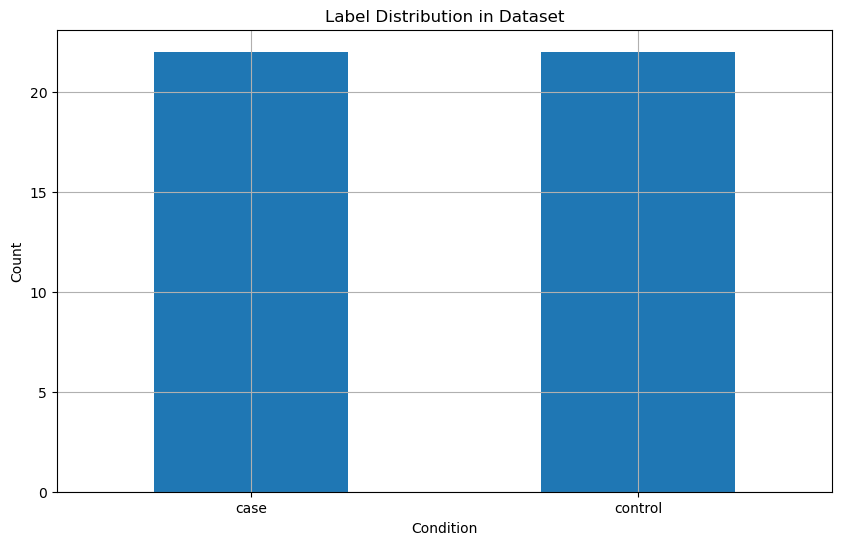

In [398]:
# Plot the distribution of labels with bar plot
plt.figure(figsize=(10, 6))
t1d_data['characteristics'].value_counts().plot(kind='bar')
plt.title('Label Distribution in Dataset')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

### **Feature Preparation**

The dataset is split into features (gene expression levels) and the target variable (case/control status). Gene expression features are standardized using StandardScaler to ensure that all genes contribute equally to distance-based models like SVM and KNN. The target labels are encoded into numerical form using LabelEncoder, converting 'case' and 'control' into 0 and 1 (or vice versa), which is required for machine learning algorithms.

In [399]:
# Split the merged dataset into features and labels
X = t1d_data.drop(columns=['characteristics', 'GSM'])
y = t1d_data['characteristics']
print("Features shape:", X.shape)
print("Labels shape:", y.shape)

Features shape: (44, 28920)
Labels shape: (44,)


In [400]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
print("Scaled features shape:", X_scaled.shape)

Scaled features shape: (44, 28920)


In [401]:
# Labe encode the targets
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

### **Lasso Feature Selection**

Lasso (Least Absolute Shrinkage and Selection Operator) regression performs both regularization and feature selection by shrinking less important feature coefficients to zero. Here, LassoCV automatically selects the optimal regularization strength using cross-validation. Features with non-zero coefficients above a small threshold (0.0005) are retained as potential biomarkers. This method identifies genes whose expression levels are most predictive of T1D status while reducing overfitting.

In [402]:
X = X_scaled
y = y_encoded

In [403]:
# Train Lasso model and perform feature selection s
lasso = LassoCV(alphas=np.logspace(-4, 4, 100), cv=10, random_state=42)
lasso.fit(X, y)
importance = np.abs(lasso.coef_)
# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
# Sort the features by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
feature_importance.reset_index(drop=True, inplace=True)
lasso_feature_importance = feature_importance[feature_importance['Importance'] > 0.0005]
# Print the selected features
print("Number of Biomarkers selected by Lasso:", len(lasso_feature_importance))
print("Selected Biomarkers using Lasso:")
lasso_feature_importance

Number of Biomarkers selected by Lasso: 72
Selected Biomarkers using Lasso:


,Feature,Importance
0,DPM1,0.142640
1,FKBP4,0.052994
2,CYP51A1,0.039912
3,RAD52,0.034862
4,LAS1L,0.034265
...,...,...
67,CCDC146,0.000738
68,PTPRVP,0.000639
69,MSH2,0.000608
70,SLC22A2,0.000591


### **Random Forest Feature Selection**

Random Forest provides a measure of feature importance based on how much each gene contributes to reducing impurity across decision trees. A Random Forest model is trained on the scaled data, and genes with importance scores above a threshold (0.003) are selected. This approach captures non-linear relationships and interactions between genes, complementing the linear assumptions of Lasso.

In [404]:
# Train Random Forest model and perform feature selection
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X, y)
importance = rf.feature_importances_
# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
# Sort the features by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
feature_importance.reset_index(drop=True, inplace=True)
rf_feature_importance = feature_importance[feature_importance['Importance'] > 0.003]
# Print the selected features
print("Number of Biomarkers selected by Random Forest:", len(rf_feature_importance))
print("Selected Biomarkers using Random Forest:")
rf_feature_importance

Number of Biomarkers selected by Random Forest: 69
Selected Biomarkers using Random Forest:


,Feature,Importance
0,SLX4IP,0.009689
1,FUT11,0.007673
2,TRIM52-AS1,0.007099
3,PLEKHA2,0.007023
4,NCDN,0.006494
...,...,...
64,BANP,0.003070
65,FASTKD2,0.003039
66,BCKDHB,0.003028
67,WDR35,0.003012


### **SVM-RFE Feature Selection**

Although the name suggests Recursive Feature Elimination (RFE), this implementation evaluates each gene individually using an SVM classifier. Genes that achieve high classification accuracy (greater than 70%) on their own are considered discriminative. This univariate filtering approach identifies genes with strong individual predictive power, which may be biologically significant.

In [405]:
# Standardize features (important for SVM)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Evaluate each feature individually using SVM with cross-validation
feature_scores = []
for feature in X_scaled.columns:
    X_single = X_scaled[[feature]]  # Keep it as DataFrame
    svm = SVC(kernel='linear', random_state=42)
    score = cross_val_score(svm, X_single, y, cv=5, scoring='accuracy').mean()
    feature_scores.append(score)

# Create a DataFrame for "importance" based on accuracy scores
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': feature_scores})

# Sort the features by importance (accuracy score)
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
feature_importance.reset_index(drop=True, inplace=True)

# Filter out features with zero importance (if any)
svmrfe_feature_importance = feature_importance[feature_importance['Importance'] > 0.7]

# Print the selected features
print("Number of Biomarkers selected by Single-Feature SVM:", len(svmrfe_feature_importance))
print("Selected Biomarkers using Single-Feature SVM:")
svmrfe_feature_importance

Number of Biomarkers selected by Single-Feature SVM: 342
Selected Biomarkers using Single-Feature SVM:


,Feature,Importance
0,RBM3,0.788889
1,PSPC1,0.788889
2,PRR22,0.766667
3,MTND2P28,0.766667
4,XRRA1,0.766667
...,...,...
337,UTP11,0.722222
338,SHLD2,0.722222
339,TNPO2,0.722222
340,ACOT9,0.722222


### **T-test for Feature Selection**

A two-sample t-test (Welch’s t-test) is applied to each gene to assess whether its mean expression level significantly differs between T1D cases and controls. Genes with a p-value below 0.05 are considered statistically significant and retained. This classical statistical method identifies differentially expressed genes, providing a biologically interpretable list of potential biomarkers.

In [406]:
# Standardize features (optional for t-test, but can keep it consistent)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Separate features by class
class_labels = np.unique(y)
group1_idx = np.where(y == class_labels[0])[0]
group2_idx = np.where(y == class_labels[1])[0]

# Perform t-test for each feature (gene)
ttest_pvalues = []
for feature in X_scaled.columns:
    group1_values = X_scaled.iloc[group1_idx][feature]
    group2_values = X_scaled.iloc[group2_idx][feature]
    stat, pvalue = ttest_ind(group1_values, group2_values, equal_var=False)  # Welch's t-test
    ttest_pvalues.append(pvalue)

# Create a DataFrame with p-values
ttest_feature_importance = pd.DataFrame({'Feature': X.columns, 'p-value': ttest_pvalues})

# Sort features by ascending p-value (most significant first)
ttest_feature_importance = ttest_feature_importance.sort_values(by='p-value')
ttest_feature_importance.reset_index(drop=True, inplace=True)

# Filter features with p-value < 0.05 (significant)
ttest_feature_importance = ttest_feature_importance[ttest_feature_importance['p-value'] < 0.05]

# Print results
print(f"Number of Biomarkers selected by t-test: {len(ttest_feature_importance)}")
print("Selected Biomarkers using t-test:")
ttest_feature_importance

Number of Biomarkers selected by t-test: 5676
Selected Biomarkers using t-test:


,Feature,p-value
0,P4HA1,1.752273e-07
1,GCFC2,1.928272e-07
2,TIMM23B,2.500474e-07
3,DIMT1,2.834528e-07
4,TXNRD3,4.264975e-07
...,...,...
5671,SH3BGR,4.985642e-02
5672,TEKT4,4.986287e-02
5673,KCTD21,4.990732e-02
5674,DDHD1,4.996429e-02


### **Accumulation of Selected Features**

To create a robust set of biomarkers, features selected by all four methods (Lasso, Random Forest, SVM, t-test) are combined into a single list. This ensemble-based feature selection approach increases confidence in the selected genes by requiring consensus across multiple methodologies. The final dataset includes only these high-confidence biomarkers and the target label, forming the basis for model training.

In [407]:
# Intersection of selected features from all three methods
lasso_features = list(set(lasso_feature_importance['Feature']))
rf_features = list(set(rf_feature_importance['Feature']))
svmrfe_features = list(set(svmrfe_feature_importance['Feature']))
ttest_features = list(set(ttest_feature_importance['Feature']))
features = list(set(lasso_features + rf_features + svmrfe_features + ttest_features))
# Print the intersection of selected features
print("Number of Selected features:", len(list(features)))
print("Selected features:")
print(list(sorted(features)))

Number of Selected features: 5709
Selected features:
['A2ML1', 'AAAS', 'AAR2', 'AARSD1', 'AASDHPPT', 'AASS', 'ABCB10', 'ABCB6', 'ABCC6.1', 'ABCC6.3', 'ABCC6P2', 'ABCD1', 'ABCD3', 'ABCE1', 'ABCF1', 'ABCF1.12', 'ABCF1.4', 'ABCF1.8', 'ABCF2', 'ABHD11', 'ABHD12', 'ABHD13', 'ABHD17A', 'ABHD17C', 'ABHD2', 'ABHD3', 'ABITRAM', 'ABLIM3', 'ABR', 'ABR.1', 'ABR.2', 'ABR.3', 'ABR.4', 'ABR.5', 'ABR.6', 'ABR.7', 'ABR.8', 'ABRACL', 'ABRAXAS2', 'ABT1', 'ABTB1', 'ACAA1', 'ACACA', 'ACACA.2', 'ACAD10', 'ACAD8', 'ACAD9', 'ACADM', 'ACADS', 'ACADSB', 'ACAP1', 'ACAP3', 'ACAT1', 'ACAT2', 'ACBD4', 'ACBD5', 'ACBD6', 'ACCS', 'ACER2', 'ACER3', 'ACIN1', 'ACOT1', 'ACOT2', 'ACOT7', 'ACOT9', 'ACOX3', 'ACP1', 'ACP2', 'ACP6', 'ACRBP', 'ACSF2', 'ACSS2', 'ACTB', 'ACTC1', 'ACTG1', 'ACTG1P24', 'ACTG1P25', 'ACTL10', 'ACTN4', 'ACTN4P1', 'ACTR10', 'ACTR1A', 'ACTR1B', 'ACTR3', 'ACTR3B', 'ACVR1', 'ACVR1C', 'ACVR2B', 'ACVR2B-AS1', 'ACY1', 'ACYP1', 'ADAM22', 'ADAM32', 'ADAM32.2', 'ADAMTS1', 'ADAMTS12.1', 'ADAMTS12.3', 'ADAMTS9', '

In [408]:
# Create a new DataFrame with the selected features and target for future uses
selected_df = pd.concat([X[list(sorted(features))], pd.Series(label_encoder.inverse_transform(y), name='Condition')], axis=1)
selected_df.rename({0:"Condition"})
print("Shape of selected dtaset:", selected_df.shape)
print("Preview of selected dataset:")
selected_df.head(10)

Shape of selected dtaset: (44, 5710)
Preview of selected dataset:


,A2ML1,AAAS,AAR2,AARSD1,AASDHPPT,AASS,ABCB10,ABCB6,ABCC6.1,ABCC6.3,...,ZSCAN20,ZSCAN26,ZSCAN32,ZSWIM6,ZW10,ZWILCH,ZYG11A,ZYX,ZZZ3,Condition
0,-0.214624,0.261221,-1.465140,-1.538158,0.085676,-1.138701,-0.444011,0.696294,1.183622,1.183622,...,1.011338,1.119590,-0.624863,-0.630246,-0.537385,-0.759360,-1.049655,-0.482260,0.838684,case
1,0.300474,-0.141556,-1.240023,-0.243450,1.743770,-0.355563,-0.585528,0.147281,-0.956626,-0.956626,...,1.554744,2.584008,-0.324500,0.424689,1.508251,0.917483,-1.049655,-1.766094,-0.384590,case
2,0.815573,-1.017158,1.275666,-0.492432,-1.572418,-1.948844,-1.632756,2.192920,-0.956626,-0.956626,...,0.166041,-0.730202,-0.496136,1.751114,-1.716061,-0.450468,-1.449524,-1.845865,-0.697359,case
3,1.330672,-1.454959,-1.358209,-0.691618,-1.211759,0.157528,-0.755349,0.718857,-0.567490,-0.567490,...,2.732123,1.264105,-0.839408,0.781505,-0.556868,1.535267,-0.783076,-0.492133,-0.085722,case
4,-0.729723,0.383806,-0.243877,0.071928,0.699264,1.372742,2.810888,-1.883316,3.323870,3.323870,...,-1.826447,-0.614590,0.340590,-1.281823,1.254981,0.888065,1.349557,1.429471,0.720527,control
5,-0.729723,1.119312,0.583430,-0.226851,1.411214,-0.382568,-0.274190,-1.386948,-0.567490,-0.567490,...,-1.313230,-1.173381,0.254772,-1.204255,0.037341,-0.538723,1.882715,1.009293,-0.308135,control
6,-0.729723,-0.736965,1.894739,1.897800,-1.094662,-1.084692,-1.080839,0.297696,-0.891770,-0.891770,...,-1.403798,-1.818882,-0.303045,0.347120,-0.732208,-0.612268,-0.649787,-0.863738,-0.259482,control
7,0.815573,1.872330,0.009380,0.470300,0.216825,2.506943,1.820267,-1.251575,0.145926,0.145926,...,0.800014,-0.325560,1.198771,-0.490622,2.160906,1.594104,2.815742,1.902172,2.068909,control
8,0.815573,1.662185,-1.104952,-0.359641,0.394812,0.103518,0.985315,1.320515,-0.372922,-0.372922,...,0.769825,2.343150,-1.204135,-0.288944,-1.082888,-1.759582,-1.182945,-0.490158,0.199245,case
9,0.300474,0.173661,0.048775,-0.542228,0.652426,-0.922663,-0.217583,1.365639,-0.826914,-0.826914,...,1.433987,1.254470,-0.367409,0.874588,1.576438,0.093771,-1.982683,-0.261114,-0.933673,case


In [ ]:
selected_df.to_csv("Data/clean_t1d_selected_knnimputed.csv", index=False)

### **Machine Learning Model Training with K-Fold Cross Validation**

A comprehensive evaluation of multiple machine learning models is conducted using 5-fold stratified cross-validation. Models include Logistic Regression, SVM, Random Forest, XGBoost, and others. To reduce dimensionality and multicollinearity, PCA is applied to retain 40 principal components. Each model is evaluated using accuracy, precision, recall, F1-score, and ROC AUC. An ensemble stacking classifier combines predictions from top-performing models using KNN as the final estimator, aiming to improve generalization.

In [ ]:
# Load dataset
data = pd.read_csv("Data/clean_t1d_selected_knnimputed.csv")
print("Shape of data:", data.shape)
print("Preview of data:")
data.head(10)

Shape of data: (44, 5710)
Preview of data:


,A2ML1,AAAS,AAR2,AARSD1,AASDHPPT,AASS,ABCB10,ABCB6,ABCC6.1,ABCC6.3,...,ZSCAN20,ZSCAN26,ZSCAN32,ZSWIM6,ZW10,ZWILCH,ZYG11A,ZYX,ZZZ3,Condition
0,-0.214624,0.261221,-1.465140,-1.538158,0.085676,-1.138701,-0.444011,0.696294,1.183622,1.183622,...,1.011338,1.119590,-0.624863,-0.630246,-0.537385,-0.759360,-1.049655,-0.482260,0.838684,case
1,0.300474,-0.141556,-1.240023,-0.243450,1.743770,-0.355563,-0.585528,0.147281,-0.956626,-0.956626,...,1.554744,2.584008,-0.324500,0.424689,1.508251,0.917483,-1.049655,-1.766094,-0.384590,case
2,0.815573,-1.017158,1.275666,-0.492432,-1.572418,-1.948844,-1.632756,2.192920,-0.956626,-0.956626,...,0.166041,-0.730202,-0.496136,1.751114,-1.716061,-0.450468,-1.449524,-1.845865,-0.697359,case
3,1.330672,-1.454959,-1.358209,-0.691618,-1.211759,0.157528,-0.755349,0.718857,-0.567490,-0.567490,...,2.732123,1.264105,-0.839408,0.781505,-0.556868,1.535267,-0.783076,-0.492133,-0.085722,case
4,-0.729723,0.383806,-0.243877,0.071928,0.699264,1.372742,2.810888,-1.883316,3.323870,3.323870,...,-1.826447,-0.614590,0.340590,-1.281823,1.254981,0.888065,1.349557,1.429471,0.720527,control
5,-0.729723,1.119312,0.583430,-0.226851,1.411214,-0.382568,-0.274190,-1.386948,-0.567490,-0.567490,...,-1.313230,-1.173381,0.254772,-1.204255,0.037341,-0.538723,1.882715,1.009293,-0.308135,control
6,-0.729723,-0.736965,1.894739,1.897800,-1.094662,-1.084692,-1.080839,0.297696,-0.891770,-0.891770,...,-1.403798,-1.818882,-0.303045,0.347120,-0.732208,-0.612268,-0.649787,-0.863738,-0.259482,control
7,0.815573,1.872330,0.009380,0.470300,0.216825,2.506943,1.820267,-1.251575,0.145926,0.145926,...,0.800014,-0.325560,1.198771,-0.490622,2.160906,1.594104,2.815742,1.902172,2.068909,control
8,0.815573,1.662185,-1.104952,-0.359641,0.394812,0.103518,0.985315,1.320515,-0.372922,-0.372922,...,0.769825,2.343150,-1.204135,-0.288944,-1.082888,-1.759582,-1.182945,-0.490158,0.199245,case
9,0.300474,0.173661,0.048775,-0.542228,0.652426,-0.922663,-0.217583,1.365639,-0.826914,-0.826914,...,1.433987,1.254470,-0.367409,0.874588,1.576438,0.093771,-1.982683,-0.261114,-0.933673,case


In [443]:
# Data preparation
X = data.drop(columns=['Condition'], axis=1)
y = data['Condition']

label_encoder = LabelEncoder()
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
y_encoded = label_encoder.fit_transform(y)

# Print label map (class name -> encoded label)
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label map:")
for label_name, encoded_label in label_map.items():
    print(f"  {label_name}:{encoded_label}")

Label map:
  case:0
  control:1


In [450]:
# Dimensionality reductuin using PCA
pca = PCA(n_components=40)
X_scaled_pca = pca.fit_transform(X_scaled)

In [ ]:
# Define the models dictionary
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'MLP': MLPClassifier(hidden_layer_sizes=(200, 50, 25), max_iter=1000, random_state=42)
}

# Define estimators for the stacking classifier (using strong models)
estimators = [
    ('Random Forest', models['Random Forest']),
    ('XGBoost', models['XGBoost']),
    ('CatBoost', models['CatBoost']),
    ('AdaBoost', models['AdaBoost']),
    ('Gradient Boosting', models['Gradient Boosting'])
]

# Stacking classifier with Logistic Regression as meta-learner
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=models['KNN'],
    cv=5,  # Cross-validation for meta-learner
    n_jobs=-1,  # Use all available cores
    passthrough=False  # Do not pass original features to meta-learner
)
models['Ensemble'] = stacking_model

# Define the number of classes based on y_encoded
n_classes = len(np.unique(y_encoded))

# Define custom scoring metrics (with macro average and zero_division=0)
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='macro', zero_division=0),
    'recall': make_scorer(recall_score, average='macro', zero_division=0),
    'f1': make_scorer(f1_score, average='macro', zero_division=0),
}

# Add ROC AUC scorer based on number of classes
if n_classes == 2:
    scoring['roc_auc'] = 'roc_auc'
else:
    scoring['roc_auc'] = 'roc_auc_ovr'  # One-vs-Rest for multi-class

# Define the cross-validation strategy (5-fold stratified)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []  # List to store performance metrics for each model

# Train each model using k-fold CV and evaluate its performance
for name, model in tqdm(models.items(), desc="Cross Validating Models ..."):
    print(f"\nCross Validating {name} ...")
    cv_results = cross_validate(model, X_scaled_pca, y_encoded, cv=cv, scoring=scoring, n_jobs=-1)
    
    # Calculate mean performance metrics across folds
    accuracy = cv_results['test_accuracy'].mean()
    precision = cv_results['test_precision'].mean()
    recall = cv_results['test_recall'].mean()
    f1 = cv_results['test_f1'].mean()
    roc_auc = cv_results['test_roc_auc'].mean() if 'test_roc_auc' in cv_results else np.nan
    
    # Print performance metrics
    print(f"Model: {name}")
    print(f"  Accuracy : {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall   : {recall:.4f}")
    print(f"  F1 Score : {f1:.4f}")
    if not np.isnan(roc_auc):
        print(f"  ROC AUC  : {roc_auc:.4f}")
    else:
        print("  ROC AUC  : Not available")
    print(f"Completed Cross Validating {name}")
    print("-" * 40)
    
    # Append results to list
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    })

print("\nAll Cross Validation Completed.")

# Store the results in a DataFrame and print
results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
print("\nSummary of Model Cross Validation Performance:")
results_df

Cross Validating Models ...:   0%|          | 0/11 [00:00<?, ?it/s]


Cross Validating Logistic Regression ...
Model: Logistic Regression
  Accuracy : 0.6806
  Precision: 0.8000
  Recall   : 0.6950
  F1 Score : 0.6523
  ROC AUC  : 0.9075
Completed Cross Validating Logistic Regression
----------------------------------------

Cross Validating SVM ...
Model: SVM
  Accuracy : 0.6806
  Precision: 0.8000
  Recall   : 0.6950
  F1 Score : 0.6523
  ROC AUC  : 0.6000
Completed Cross Validating SVM
----------------------------------------

Cross Validating KNN ...
Model: KNN
  Accuracy : 0.6139
  Precision: 0.6367
  Recall   : 0.6250
  F1 Score : 0.6088
  ROC AUC  : 0.6125
Completed Cross Validating KNN
----------------------------------------

Cross Validating Random Forest ...
Model: Random Forest
  Accuracy : 0.8639
  Precision: 0.8898
  Recall   : 0.8550
  F1 Score : 0.8562
  ROC AUC  : 0.9500
Completed Cross Validating Random Forest
----------------------------------------

Cross Validating XGBoost ...
Model: XGBoost
  Accuracy : 0.8139
  Precision: 0.8364
 

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,AdaBoost,0.886111,0.896667,0.880,0.881097,0.94375
1,Random Forest,0.863889,0.889762,0.855,0.856227,0.95000
2,Ensemble,0.861111,0.883333,0.855,0.853160,0.93750
3,CatBoost,0.861111,0.888333,0.855,0.854913,0.93500
4,Gradient Boosting,0.838889,0.871429,0.830,0.826537,0.91500
5,XGBoost,0.813889,0.836429,0.805,0.805433,0.84250
6,Logistic Regression,0.680556,0.800000,0.695,0.652338,0.90750
7,SVM,0.680556,0.800000,0.695,0.652338,0.60000
8,MLP,0.658333,0.792857,0.675,0.622468,0.92500
9,KNN,0.613889,0.636667,0.625,0.608810,0.61250


In [ ]:

# Save the model results
results_df.to_csv('results/t1d_base_predictive_model_performance.csv', index=False)
print("Performance for Base Model Saved")

Performance for Base Model Saved


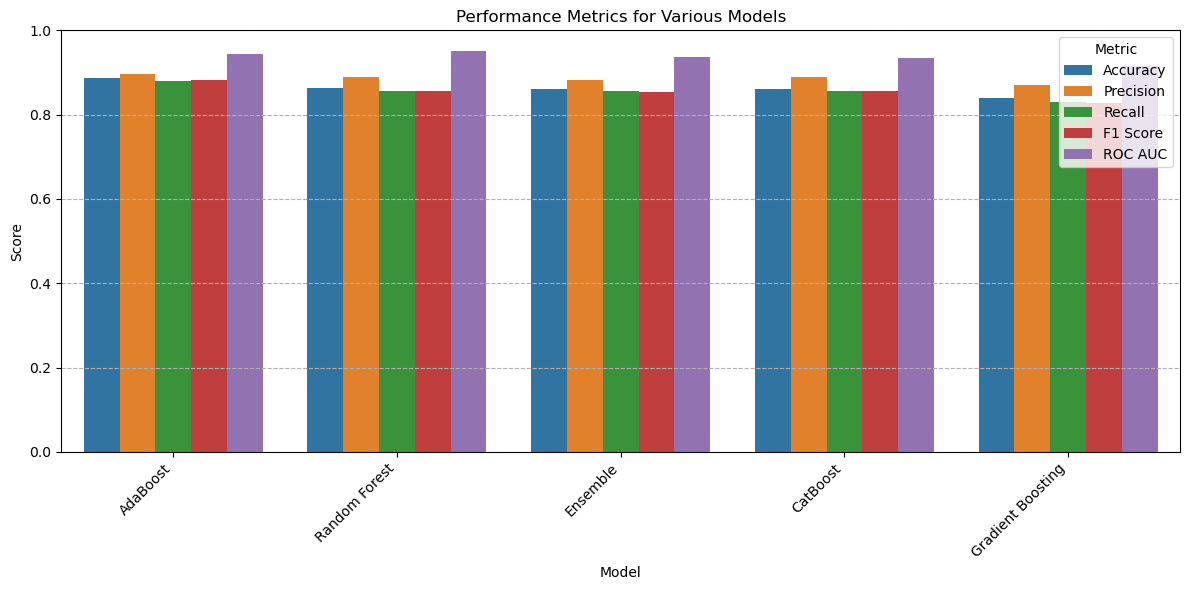

In [ ]:
# Plot the performance metrics
# Melt the results_df so that each row represents a metric score for a given model
results_df_top = results_df.nlargest(n=5, columns=['Accuracy'])
results_melted = results_df_top.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric')
plt.title("Performance Metrics for Various Models")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--')
plt.ylim([0, 1])
plt.tight_layout()

# Save the figure
plt.savefig('results/t1d_predictive_model_performance.png')
# Show the plot
plt.show()

### **Hyperparameter Optimization**

To further improve model performance, hyperparameter tuning is performed using Optuna, a Bayesian optimization framework. Five top-performing models—AdaBoost, Random Forest, CatBoost, Gradient Boosting, and XGBoost—are tuned over 100 trials each. The objective is to maximize cross-validation accuracy. Optimal hyperparameters are identified and used to retrain the models. A new stacking ensemble is built using these tuned models, and their performance is re-evaluated using the same cross-validation setup.

In [479]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective_ada(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
    }
    model = AdaBoostClassifier(**params, random_state=42)
    return cross_val_score(model, X_scaled_pca, y_encoded, cv=cv, scoring='accuracy', n_jobs=-1).mean()

def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
    }
    model = RandomForestClassifier(**params, random_state=42)
    return cross_val_score(model, X_scaled_pca, y_encoded, cv=cv, scoring='accuracy', n_jobs=-1).mean()

def objective_catboost(trial):
    params = {
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255)
    }
    model = CatBoostClassifier(**params, verbose=0, random_state=42)
    return cross_val_score(model, X_scaled_pca, y_encoded, cv=cv, scoring='accuracy', n_jobs=-1).mean()

def objective_gb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0)
    }
    model = GradientBoostingClassifier(**params, random_state=42)
    return cross_val_score(model, X_scaled_pca, y_encoded, cv=cv, scoring='accuracy', n_jobs=-1).mean()

def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'eval_metric': 'logloss',
        'random_state': 42
    }
    model = XGBClassifier(**params)
    return cross_val_score(model, X_scaled_pca, y_encoded, cv=cv, scoring='accuracy', n_jobs=-1).mean()

# Map model names to objectives
objectives = {
    'AdaBoost': objective_ada,
    'Random Forest': objective_rf,
    'CatBoost': objective_catboost,
    'Gradient Boosting': objective_gb,
    'XGBoost': objective_xgb,
}

best_params = {}
n_trials = 100

for model_name, objective in objectives.items():
    print(f"Starting tuning for {model_name} ...")
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    best_params[model_name] = study.best_params
    print(f"Best params for {model_name}: {study.best_params}")
    print(f"Best accuracy: {study.best_value:.4f}\n")

[I 2025-08-10 20:05:39,834] A new study created in memory with name: no-name-d3c9727a-7002-4771-946d-a1054b4f4ea9


Starting tuning for AdaBoost ...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-10 20:05:40,890] Trial 0 finished with value: 0.8638888888888889 and parameters: {'n_estimators': 277, 'learning_rate': 0.4211265710634895}. Best is trial 0 with value: 0.8638888888888889.
[I 2025-08-10 20:05:41,783] Trial 1 finished with value: 0.8638888888888889 and parameters: {'n_estimators': 317, 'learning_rate': 0.32377416879967885}. Best is trial 0 with value: 0.8638888888888889.
[I 2025-08-10 20:05:42,878] Trial 2 finished with value: 0.8416666666666666 and parameters: {'n_estimators': 453, 'learning_rate': 0.31871557822332863}. Best is trial 0 with value: 0.8638888888888889.
[I 2025-08-10 20:05:43,540] Trial 3 finished with value: 0.836111111111111 and parameters: {'n_estimators': 125, 'learning_rate': 0.05238532577530695}. Best is trial 0 with value: 0.8638888888888889.
[I 2025-08-10 20:05:43,957] Trial 4 finished with value: 0.836111111111111 and parameters: {'n_estimators': 379, 'learning_rate': 0.0161138923453789}. Best is trial 0 with value: 0.8638888888888889.

[I 2025-08-10 20:06:17,431] A new study created in memory with name: no-name-05eaa977-8976-438f-89f2-7ef15589e422


[I 2025-08-10 20:06:17,430] Trial 99 finished with value: 0.836111111111111 and parameters: {'n_estimators': 348, 'learning_rate': 0.0133711893749404}. Best is trial 26 with value: 0.8861111111111111.
Best params for AdaBoost: {'n_estimators': 423, 'learning_rate': 0.7300608500092896}
Best accuracy: 0.8861

Starting tuning for Random Forest ...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-10 20:06:17,690] Trial 0 finished with value: 0.5888888888888888 and parameters: {'n_estimators': 283, 'max_depth': 12, 'min_samples_split': 18, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5888888888888888.
[I 2025-08-10 20:06:17,897] Trial 1 finished with value: 0.45555555555555555 and parameters: {'n_estimators': 255, 'max_depth': 26, 'min_samples_split': 3, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 0 with value: 0.5888888888888888.
[I 2025-08-10 20:06:18,152] Trial 2 finished with value: 0.45555555555555555 and parameters: {'n_estimators': 332, 'max_depth': 7, 'min_samples_split': 17, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5888888888888888.
[I 2025-08-10 20:06:18,438] Trial 3 finished with value: 0.5444444444444445 and parameters: {'n_estimators': 351, 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 0 with value: 0.588888888

[I 2025-08-10 20:07:10,808] A new study created in memory with name: no-name-396e0f9e-d6ff-4895-b876-d1d2d79b2e3d


[I 2025-08-10 20:07:10,807] Trial 99 finished with value: 0.8638888888888889 and parameters: {'n_estimators': 496, 'max_depth': 22, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 11 with value: 0.9083333333333332.
Best params for Random Forest: {'n_estimators': 767, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best accuracy: 0.9083

Starting tuning for CatBoost ...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-10 20:07:14,109] Trial 0 finished with value: 0.75 and parameters: {'depth': 10, 'learning_rate': 0.14272912299728455, 'iterations': 317, 'l2_leaf_reg': 0.003985593431496364, 'border_count': 186}. Best is trial 0 with value: 0.75.
[I 2025-08-10 20:07:17,764] Trial 1 finished with value: 0.9083333333333332 and parameters: {'depth': 8, 'learning_rate': 0.23147795084586875, 'iterations': 815, 'l2_leaf_reg': 1.824129884197628, 'border_count': 239}. Best is trial 1 with value: 0.9083333333333332.
[I 2025-08-10 20:07:19,706] Trial 2 finished with value: 0.8833333333333332 and parameters: {'depth': 7, 'learning_rate': 0.10573080300369403, 'iterations': 667, 'l2_leaf_reg': 0.21191335182103824, 'border_count': 164}. Best is trial 1 with value: 0.9083333333333332.
[I 2025-08-10 20:07:20,745] Trial 3 finished with value: 0.8833333333333332 and parameters: {'depth': 6, 'learning_rate': 0.023859411574475624, 'iterations': 506, 'l2_leaf_reg': 3.294966920025535, 'border_count': 44}. Best i

[I 2025-08-10 20:11:22,041] A new study created in memory with name: no-name-aaf686af-65b2-47c0-b964-5a299814ca53


[I 2025-08-10 20:11:22,040] Trial 99 finished with value: 0.861111111111111 and parameters: {'depth': 5, 'learning_rate': 0.010010036355611002, 'iterations': 423, 'l2_leaf_reg': 4.240977660001461, 'border_count': 125}. Best is trial 63 with value: 0.9305555555555556.
Best params for CatBoost: {'depth': 5, 'learning_rate': 0.15262688468040386, 'iterations': 779, 'l2_leaf_reg': 1.1361450198586107, 'border_count': 74}
Best accuracy: 0.9306

Starting tuning for Gradient Boosting ...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-10 20:11:22,262] Trial 0 finished with value: 0.7055555555555555 and parameters: {'n_estimators': 384, 'learning_rate': 0.12327901152965724, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 14, 'subsample': 0.9689852455700073}. Best is trial 0 with value: 0.7055555555555555.
[I 2025-08-10 20:11:22,649] Trial 1 finished with value: 0.7277777777777776 and parameters: {'n_estimators': 770, 'learning_rate': 0.06271766222226922, 'max_depth': 12, 'min_samples_split': 12, 'min_samples_leaf': 9, 'subsample': 0.6450527744564899}. Best is trial 1 with value: 0.7277777777777776.
[I 2025-08-10 20:11:22,795] Trial 2 finished with value: 0.47777777777777775 and parameters: {'n_estimators': 308, 'learning_rate': 0.07040120926468936, 'max_depth': 15, 'min_samples_split': 20, 'min_samples_leaf': 14, 'subsample': 0.5192594163694855}. Best is trial 1 with value: 0.7277777777777776.
[I 2025-08-10 20:11:23,102] Trial 3 finished with value: 0.836111111111111 and parameters: {'n_estima

[I 2025-08-10 20:12:03,240] A new study created in memory with name: no-name-64d31aa7-9db7-4aa8-8df4-31ccb5e8b32f


[I 2025-08-10 20:12:03,238] Trial 99 finished with value: 0.8861111111111111 and parameters: {'n_estimators': 424, 'learning_rate': 0.16162914511379325, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 3, 'subsample': 0.7913562690580325}. Best is trial 52 with value: 0.9305555555555556.
Best params for Gradient Boosting: {'n_estimators': 810, 'learning_rate': 0.021629091319927143, 'max_depth': 15, 'min_samples_split': 19, 'min_samples_leaf': 4, 'subsample': 0.816685022589326}
Best accuracy: 0.9306

Starting tuning for XGBoost ...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-10 20:12:03,903] Trial 0 finished with value: 0.45555555555555555 and parameters: {'n_estimators': 576, 'max_depth': 13, 'learning_rate': 0.01764991470876496, 'subsample': 0.5719618067812335, 'colsample_bytree': 0.54232950091087, 'gamma': 2.2787481386450064, 'reg_alpha': 4.024695711014185, 'reg_lambda': 0.2563028362262376}. Best is trial 0 with value: 0.45555555555555555.
[I 2025-08-10 20:12:05,150] Trial 1 finished with value: 0.45555555555555555 and parameters: {'n_estimators': 320, 'max_depth': 5, 'learning_rate': 0.019655481214392822, 'subsample': 0.938697491722259, 'colsample_bytree': 0.9683136569672488, 'gamma': 1.5038715236699929, 'reg_alpha': 3.954431904695157, 'reg_lambda': 4.205632127041385}. Best is trial 0 with value: 0.45555555555555555.
[I 2025-08-10 20:12:06,262] Trial 2 finished with value: 0.45555555555555555 and parameters: {'n_estimators': 390, 'max_depth': 8, 'learning_rate': 0.05024853005525821, 'subsample': 0.7563004295403907, 'colsample_bytree': 0.5092

In [481]:
ada_params = {'n_estimators': 423, 'learning_rate': 0.7300608500092896}
rf_params = {'n_estimators': 767, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
cat_params = {'depth': 5, 'learning_rate': 0.15262688468040386, 'iterations': 779, 'l2_leaf_reg': 1.1361450198586107, 'border_count': 74}
gb_params = {'n_estimators': 810, 'learning_rate': 0.021629091319927143, 'max_depth': 15, 'min_samples_split': 19, 'min_samples_leaf': 4, 'subsample': 0.816685022589326}
xgb_params = {'n_estimators': 821, 'max_depth': 3, 'learning_rate': 0.022626999681824245, 'subsample': 0.7970088826168483, 'colsample_bytree': 0.8115427798277244, 'gamma': 1.1231868437826464, 'reg_alpha': 0.4589995116997439, 'reg_lambda': 2.718280580801548}

tuned_models = {
    'Random Forest': RandomForestClassifier(random_state=42, **rf_params),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42, **xgb_params),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, **gb_params),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0, **cat_params),
    'AdaBoost': AdaBoostClassifier(random_state=42, **ada_params)
}

tuned_estimators = [(name, model) for name, model in tuned_models.items()]

# Stacking classifier with Logistic Regression as meta-learner
stacking_model = StackingClassifier(
    estimators=tuned_estimators,
    final_estimator=LogisticRegression(),
    cv=5,  # Cross-validation for meta-learner
    n_jobs=-1,  # Use all available cores
    passthrough=False  # Do not pass original features to meta-learner
)
tuned_models['Ensemble'] = stacking_model

# Define the number of classes based on y_encoded
n_classes = len(np.unique(y_encoded))

# Define custom scoring metrics (with macro average and zero_division=0)
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='macro', zero_division=0),
    'recall': make_scorer(recall_score, average='macro', zero_division=0),
    'f1': make_scorer(f1_score, average='macro', zero_division=0),
}

# Add ROC AUC scorer based on number of classes
if n_classes == 2:
    scoring['roc_auc'] = 'roc_auc'
else:
    scoring['roc_auc'] = 'roc_auc_ovr'  # One-vs-Rest for multi-class

# Define the cross-validation strategy (5-fold stratified)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []  # List to store performance metrics for each model

# Train each model using k-fold CV and evaluate its performance
for name, model in tqdm(tuned_models.items(), desc="Cross Validating Models ..."):
    print(f"\nCross Validating {name} ...")
    cv_results = cross_validate(model, X_scaled_pca, y_encoded, cv=cv, scoring=scoring, n_jobs=-1)
    
    # Calculate mean performance metrics across folds
    accuracy = cv_results['test_accuracy'].mean()
    precision = cv_results['test_precision'].mean()
    recall = cv_results['test_recall'].mean()
    f1 = cv_results['test_f1'].mean()
    roc_auc = cv_results['test_roc_auc'].mean() if 'test_roc_auc' in cv_results else np.nan
    
    # Print performance metrics
    print(f"Model: {name}")
    print(f"  Accuracy : {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall   : {recall:.4f}")
    print(f"  F1 Score : {f1:.4f}")
    if not np.isnan(roc_auc):
        print(f"  ROC AUC  : {roc_auc:.4f}")
    else:
        print("  ROC AUC  : Not available")
    print(f"Completed Cross Validating {name}")
    print("-" * 40)
    
    # Append results to list
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    })

print("\nAll Cross Validation Completed.")

# Store the results in a DataFrame and print
results_df_tuned = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
print("\nSummary of Hyperparameter Tuned Model Cross Validation Performance:")
results_df_tuned

Cross Validating Models ...:   0%|          | 0/6 [00:00<?, ?it/s]


Cross Validating Random Forest ...
Model: Random Forest
  Accuracy : 0.9083
  Precision: 0.9267
  Recall   : 0.9050
  F1 Score : 0.9056
  ROC AUC  : 0.9375
Completed Cross Validating Random Forest
----------------------------------------

Cross Validating XGBoost ...
Model: XGBoost
  Accuracy : 0.8639
  Precision: 0.8864
  Recall   : 0.8600
  F1 Score : 0.8574
  ROC AUC  : 0.9425
Completed Cross Validating XGBoost
----------------------------------------

Cross Validating Gradient Boosting ...
Model: Gradient Boosting
  Accuracy : 0.9306
  Precision: 0.9467
  Recall   : 0.9250
  F1 Score : 0.9278
  ROC AUC  : 0.9450
Completed Cross Validating Gradient Boosting
----------------------------------------

Cross Validating CatBoost ...
Model: CatBoost
  Accuracy : 0.9306
  Precision: 0.9467
  Recall   : 0.9250
  F1 Score : 0.9278
  ROC AUC  : 0.9450
Completed Cross Validating CatBoost
----------------------------------------

Cross Validating AdaBoost ...
Model: AdaBoost
  Accuracy : 0.886

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,CatBoost,0.930556,0.946667,0.925,0.927850,0.94500
1,Gradient Boosting,0.930556,0.946667,0.925,0.927850,0.94500
2,Ensemble,0.930556,0.946667,0.925,0.927850,0.96000
3,Random Forest,0.908333,0.926667,0.905,0.905628,0.93750
4,AdaBoost,0.886111,0.896667,0.880,0.881097,0.91375
5,XGBoost,0.863889,0.886429,0.860,0.857381,0.94250


In [ ]:
results_df_tuned.to_csv('results/t1d_hp_tuned_predictive_model_performance.csv')

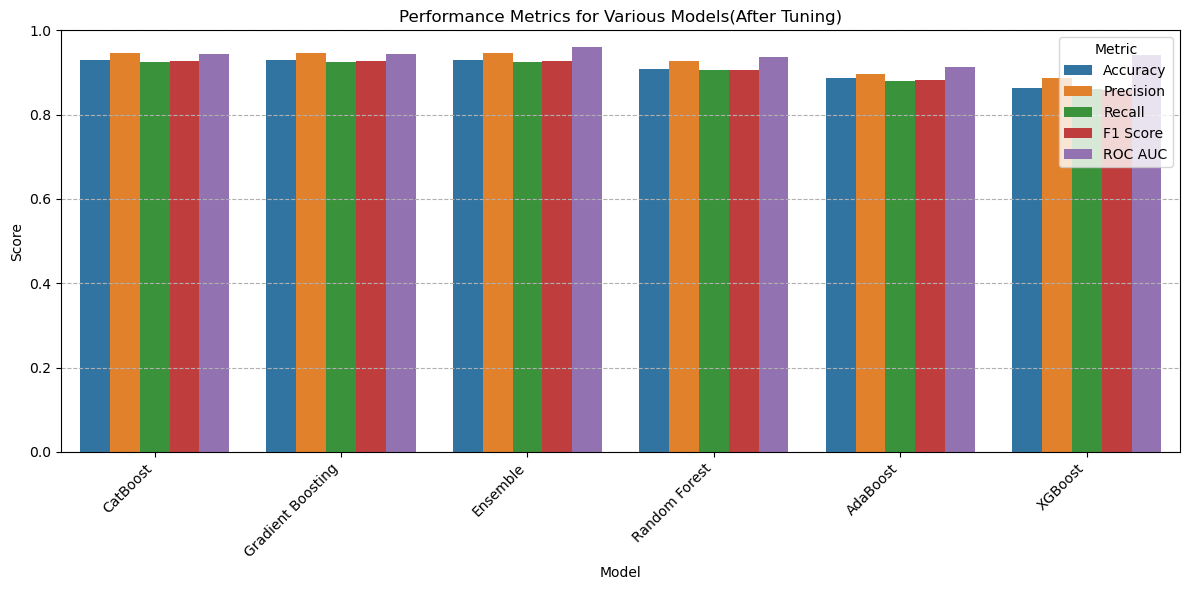

In [ ]:
# Plot the performance metrics
# Melt the results_df so that each row represents a metric score for a given model
results_df_top_tuned = results_df_tuned.nlargest(n=6, columns=['Accuracy'])
results_melted_tuned = results_df_top_tuned.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=results_melted_tuned, x='Model', y='Score', hue='Metric')
plt.title("Performance Metrics for Various Models(After Tuning)")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--')
plt.ylim([0, 1])
plt.tight_layout()

# Save the figure
plt.savefig('results/t1d_tuned_predictive_model_performance.png')
# Show the plot
plt.show()